# 1. 扩散方程
$$
\frac{\partial y}{\partial t} = \frac{\partial^2y}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)),   \qquad x \in [-1, 1], \quad t \in [0, 1]
$$
且包含初始条件：
$$
y(x, 0) = \sin(\pi x)
$$
以及狄利克雷边界条件：
$$
y(-1, t) = y(1, t) = 0.
$$
其参考解为
$$
y = e^{-t} \sin(\pi x)
$$



In [9]:
import deepxde as dde
import numpy as np
from deepxde.backend import torch

In [2]:
# 定义计算域
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [10]:
# 定义PDE系统
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t - dy_xx + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )
    

In [11]:
# 描述边界
def func(x):
    return np.exp(-x[:, 1:]) * np.sin(np.pi * x[:, 0:1])

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary:on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial:on_initial)

data = dde.data.TimePDE(
    geomtime, 
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10, 
    solution=func,
    num_test=10000,
)


In [12]:
# 搭建网络
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [13]:
# 建立模型
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, tran_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.000399 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.60e+01, 2.95e-02, 4.94e-01]    [1.70e+01, 2.95e-02, 4.94e-01]    [1.06e+00]    
1000      [2.47e-03, 2.75e-03, 5.43e-04]    [4.66e-03, 2.75e-03, 5.43e-04]    [7.99e-02]    
2000      [1.50e-03, 5.45e-04, 2.16e-04]    [1.38e-03, 5.45e-04, 2.16e-04]    [3.39e-02]    
3000      [2.23e-04, 7.80e-05, 5.85e-05]    [4.33e-04, 7.80e-05, 5.85e-05]    [1.66e-02]    
4000      [1.16e-04, 1.46e-05, 1.06e-05]    [2.86e-04, 1.46e-05, 1.06e-05]    [8.55e-03]    
5000      [7.09e-05, 4.16e-06, 2.95e-06]    [2.48e-04, 4.16e-06, 2.95e-06]    [6.27e-03]    
6000      [6.23e-05, 3.22e-06, 1.59e-06]    [2.10e-04, 3.22e-06, 1.59e-06]    [5.94e-03]    
7000      [9.25e-05, 5.43e-06, 2.88e-06]    [1.84e-04, 5.43e-06, 2.88e-06]    [6.05e-03]    
8000      [8.16e-04, 5.01e-05, 7.81e-06]    [6.71e-04, 5.01e-05, 7.81e-06]    [1.10e-02]    
9000 

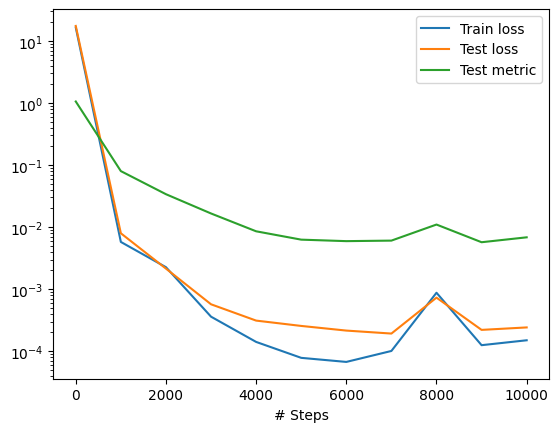

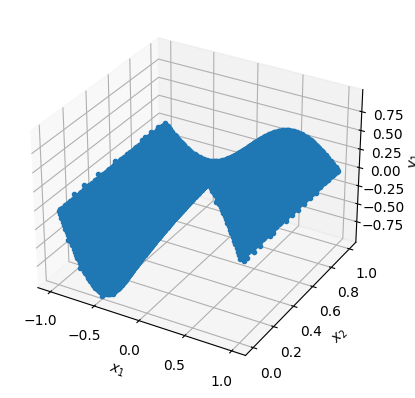

In [14]:
dde.saveplot(losshistory, tran_state, issave=False, isplot=True)

# 2. 硬初始条件与硬边界条件
跟前面的相比，我们只需要增加一个transorm层
可以使用
$$
t(1-x^2)y + sin(\pi x)
$$

Compiling model...
'compile' took 0.000205 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.34e+00]    [5.63e+00]    [4.86e-01]    
1000      [1.36e-03]    [1.85e-03]    [4.11e-03]    
2000      [1.97e-04]    [4.23e-04]    [1.65e-03]    
3000      [8.46e-05]    [2.61e-04]    [1.18e-03]    
4000      [1.99e-04]    [3.68e-04]    [2.35e-03]    
5000      [3.99e-05]    [1.56e-04]    [8.85e-04]    
6000      [3.74e-05]    [1.36e-04]    [9.31e-04]    
7000      [2.21e-05]    [9.47e-05]    [7.25e-04]    
8000      [1.62e-05]    [7.41e-05]    [6.62e-04]    
9000      [1.27e-05]    [6.15e-05]    [6.21e-04]    
10000     [1.33e-05]    [6.16e-05]    [6.42e-04]    

Best model at step 9000:
  train loss: 1.27e-05
  test loss: 6.15e-05
  test metric: [6.21e-04]

'train' took 46.175240 s



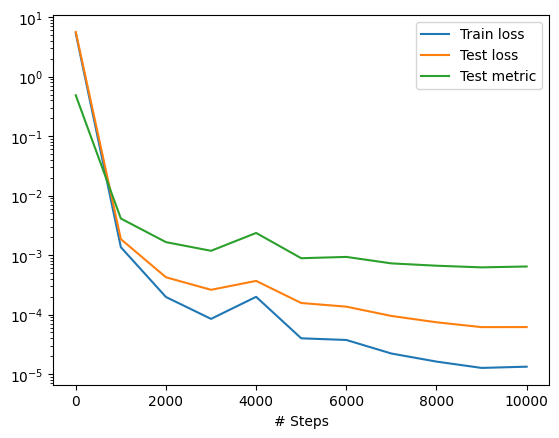

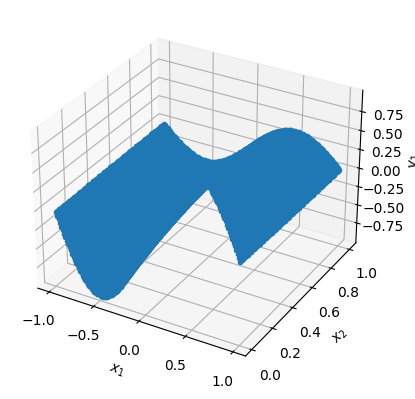

In [16]:
# 定义PDE系统
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t - dy_xx + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(geomtime, pde, [], num_domain=40, solution=func, num_test=10000)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_output_transform(
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + torch.sin(np.pi * x[:, 0:1])
)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# 3. 扩散方程的逆问题
包含未知参数**C**的方程如下：
$$
\frac{\partial y}{\partial t} = C\frac{\partial^2y}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)),   \qquad x \in [-1, 1], \quad t \in [0, 1]
$$

且包含初始条件：
$$
y(x, 0) = \sin(\pi x)
$$
以及狄利克雷边界条件：
$$
y(-1, t) = y(1, t) = 0.
$$
其参考解为
$$
y = e^{-t} \sin(\pi x)
$$



In [33]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


C = dde.Variable(2.0)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
        dy_t
        - C * dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)


observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Compiling model...
'compile' took 0.000192 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.43e+01, 1.71e-02, 4.90e-01, 1.05e-01]    [1.66e+01, 1.71e-02, 4.90e-01, 1.05e-01]    [1.01e+00]    
0 [2.00e+00]
1000      [6.27e-03, 1.84e-02, 4.49e-02, 1.45e-02]    [7.03e-03, 1.84e-02, 4.49e-02, 1.45e-02]    [4.02e-01]    
1000 [1.97e+00]
2000      [1.64e-03, 4.24e-03, 1.02e-02, 7.74e-03]    [2.65e-03, 4.24e-03, 1.02e-02, 7.74e-03]    [4.01e-01]    
2000 [1.70e+00]
3000      [7.39e-04, 9.53e-04, 9.24e-04, 4.32e-03]    [7.44e-03, 9.53e-04, 9.24e-04, 4.32e-03]    [2.87e-01]    
3000 [1.44e+00]
4000      [2.68e-04, 3.85e-04, 8.31e-06, 1.74e-03]    [4.43e-03, 3.85e-04, 8.31e-06, 1.74e-03]    [1.74e-01]    
4000 [1.24e+00]
5000      [1.71e-04, 1.18e-04, 1.42e-05, 3.52e-04]    [1.46e-03, 1.18e-04, 1.42e-05, 3.52e-04]    [7.59e-02]    
5000 [1.09e+00]
6000      [1.58e-04, 3.99e-05, 7.11e-06, 4.38e-05] 

In [36]:
variable.value

[0.9993918538093567]

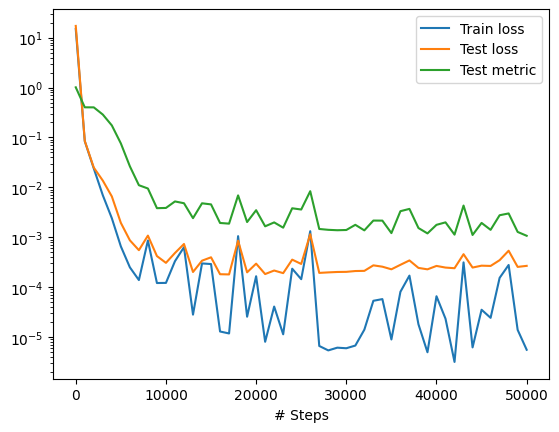

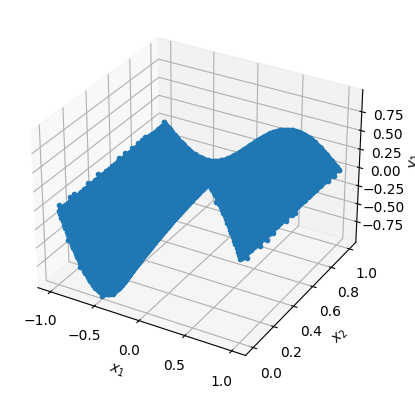

In [37]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [19]:
help(dde.callbacks.PDEPointResampler)

Help on class PDEPointResampler in module deepxde.callbacks:

class PDEPointResampler(Callback)
 |  PDEPointResampler(period=100, pde_points=True, bc_points=False)
 |  
 |  Resample the training points for PDE and/or BC losses every given period.
 |  
 |  Args:
 |      period: How often to resample the training points (default is 100 iterations).
 |      pde_points: If True, resample the training points for PDE losses (default is
 |          True).
 |      bc_points: If True, resample the training points for BC losses (default is
 |          False; only supported by pytorch backend currently).
 |  
 |  Method resolution order:
 |      PDEPointResampler
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, period=100, pde_points=True, bc_points=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  on_epoch_end(self)
 |      Called at the end of every epoch.
 |  
 |  on_train_begin(self)
 |      Called at the begi